In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-04-03 13:19:47--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.138.104, 16.15.216.173, 52.217.192.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.138.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  4.65MB/s    in 2.8s    

2025-04-03 13:19:51 (4.65 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [6]:

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

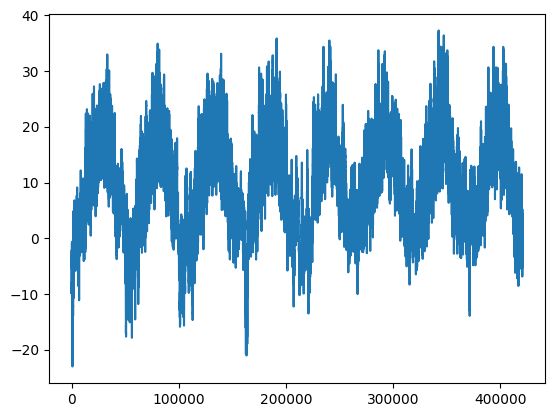

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

In [8]:
print("Temperature Data Shape:", temperature.shape)
print("First 5 Temperature Values:", temperature[:5])

print("Raw Data Shape:", raw_data.shape)
print("First 5 Rows of Raw Data:\n", raw_data[:5])


Temperature Data Shape: (420451,)
First 5 Temperature Values: [-8.02 -8.41 -8.51 -8.31 -8.27]
Raw Data Shape: (420451, 14)
First 5 Rows of Raw Data:
 [[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
   3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
   1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]
 [ 9.96570e+02 -8.41000e+00  2.65010e+02 -9.28000e+00  9.34000e+01
   3.23000e+00  3.02000e+00  2.10000e-01  1.89000e+00  3.03000e+00
   1.30980e+03  7.20000e-01  1.50000e+00  1.36100e+02]
 [ 9.96530e+02 -8.51000e+00  2.64910e+02 -9.31000e+00  9.39000e+01
   3.21000e+00  3.01000e+00  2.00000e-01  1.88000e+00  3.02000e+00
   1.31024e+03  1.90000e-01  6.30000e-01  1.71600e+02]
 [ 9.96510e+02 -8.31000e+00  2.65120e+02 -9.07000e+00  9.42000e+01
   3.26000e+00  3.07000e+00  1.90000e-01  1.92000e+00  3.08000e+00
   1.30919e+03  3.40000e-01  5.00000e-01  1.98000e+02]
 [ 9.96510e+02 -8.27000e+00  2.65150e+02 -9.04000e+00  9.41000e+01
   3.27000e+00  3.08000e+00

In [14]:
# Normalize features using StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(raw_data)
# Setting all the parameters
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# Split data into train (70%), validation (15%), test (15%)
num_train_samples = int(0.7 * (len(normalized_data) - delay))
num_val_samples = int(0.15 * (len(normalized_data) - delay))
num_test_samples = (len(normalized_data) - delay) - (num_train_samples + num_val_samples)

# Create time series datasets
train_dataset = keras.utils.timeseries_dataset_from_array(
    normalized_data[:-delay],  # Use normalized features
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    normalized_data[:-delay],  # Use normalized features
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    normalized_data[:-delay],  # Use normalized features
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=False,  # No need to shuffle test data
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

# Print dataset information
print(f"Train samples: {num_train_samples}")
print(f"Validation samples: {num_val_samples}")
print(f"Test samples: {num_test_samples}")

Train samples: 293715
Validation samples: 62938
Test samples: 62940


## 1. Building RNN Model

In [16]:
# Define the RNN model
model = keras.Sequential([
    layers.SimpleRNN(64, return_sequences=True, input_shape=(sequence_length, normalized_data.shape[1])),
    layers.SimpleRNN(16),
    layers.Dense(1)  # Output layer (predicting temperature)
])

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 120, 64)             │           5,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 16)                  │           1,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,369 (24.88 KB)

 Trainable params: 6,369 (24.88 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset
)

Epoch 1/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - loss: 8.0001 - mae: 2.2045 - val_loss: 10.3464 - val_mae: 2.4957
Epoch 2/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 8.7823 - mae: 2.3166 - val_loss: 10.4396 - val_mae: 2.5073
Epoch 3/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - loss: 8.4120 - mae: 2.2675 - val_loss: 10.6918 - val_mae: 2.5391
Epoch 4/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 86s 43ms/step - loss: 8.0375 - mae: 2.2134 - val_loss: 11.1530 - val_mae: 2.5700
Epoch 5/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - loss: 7.5013 - mae: 2.1388 - val_loss: 11.3324 - val_mae: 2.5954
Epoch 6/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 86s 44ms/step - loss: 7.1449 - mae: 2.0857 - val_loss: 10.9531 - val_mae: 2.5578
Epoch 7/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 50s 43ms/step - loss: 7.9271 - mae: 2.1944 - val_loss: 10.9424 - val_mae: 2.5470
Epoch 8/20
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 78s 40ms/step - loss: 8.3401 - mae: 2.2532 - val_loss: 11.0392 - val_mae: 2.5707
Epoch 9/20
1145/

## Adjusting The number of Units for Stacked RNN

In [19]:
# Define the improved RNN model
model = keras.Sequential([
    layers.SimpleRNN(64, return_sequences=True, input_shape=(sequence_length, normalized_data.shape[1])),
    layers.SimpleRNN(32, return_sequences=True),
    layers.SimpleRNN(16),
    layers.Dense(1)  # Output layer (predicting temperature)
])

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 120, 64)             │           5,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 120, 32)             │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 16)                  │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,961 (35.00 KB)

 Trainable params: 8,961 (35.00 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=30,  # Increased epochs for better learning
    validation_data=val_dataset
)

Epoch 1/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - loss: 48.5684 - mae: 5.0983 - val_loss: 15.4745 - val_mae: 2.8711
Epoch 2/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - loss: 11.7837 - mae: 2.5989 - val_loss: 11.8636 - val_mae: 2.6327
Epoch 3/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 49s 43ms/step - loss: 10.5153 - mae: 2.5170 - val_loss: 10.6655 - val_mae: 2.5220
Epoch 4/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - loss: 9.8305 - mae: 2.4399 - val_loss: 10.3715 - val_mae: 2.4837
Epoch 5/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - loss: 9.4927 - mae: 2.3983 - val_loss: 10.9828 - val_mae: 2.5595
Epoch 6/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - loss: 9.4448 - mae: 2.3936 - val_loss: 10.2837 - val_mae: 2.4738
Epoch 7/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - loss: 9.1271 - mae: 2.3509 - val_loss: 10.5365 - val_mae: 2.5191
Epoch 8/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - loss: 9.0076 - mae: 2.3357 - val_loss: 10.7726 - val_mae: 2.5441
Epoch 9/30
11

## Model using GRU

In [21]:
# Define the GRU model
model_gru = keras.Sequential([
    layers.GRU(64, return_sequences=True, input_shape=(sequence_length, normalized_data.shape[1])),
    layers.GRU(32, return_sequences=True),
    layers.GRU(16),
    layers.Dense(1)  # Output layer (predicting temperature)
])

# Compile the model
model_gru.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Display model summary
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 120, 64)             │          15,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 120, 32)             │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 16)                  │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,185 (106.19 KB)

 Trainable params: 27,185 (106.19 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the model
history_gru = model_gru.fit(
    train_dataset,
    epochs=30,  # Same as LSTM for comparison
    validation_data=val_dataset
)

Epoch 1/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 59s 48ms/step - loss: 57.3817 - mae: 5.5765 - val_loss: 16.0480 - val_mae: 2.8626
Epoch 2/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - loss: 10.5862 - mae: 2.4210 - val_loss: 12.5172 - val_mae: 2.7207
Epoch 3/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - loss: 5.8645 - mae: 1.8403 - val_loss: 13.1166 - val_mae: 2.8252
Epoch 4/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - loss: 3.7873 - mae: 1.4840 - val_loss: 13.2117 - val_mae: 2.8620
Epoch 5/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 56s 49ms/step - loss: 2.7636 - mae: 1.2742 - val_loss: 13.8203 - val_mae: 2.9314
Epoch 6/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - loss: 2.1966 - mae: 1.1429 - val_loss: 14.4307 - val_mae: 3.0008
Epoch 7/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 56s 49ms/step - loss: 1.8224 - mae: 1.0444 - val_loss: 14.8544 - val_mae: 3.0393
Epoch 8/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - loss: 1.5887 - mae: 0.9752 - val_loss: 15.3161 - val_mae: 3.0751
Epoch 9/30
114

## 2. Using LSTM Layers instead of GRU

In [23]:
# Define the LSTM model
model_lstm = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, normalized_data.shape[1])),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(16),
    layers.Dense(1)  # Output layer (predicting temperature)
])

# Compile the model
model_lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Display model summary
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 120, 64)             │          20,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 120, 32)             │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,793 (139.82 KB)

 Trainable params: 35,793 (139.82 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model
history_lstm = model_lstm.fit(
    train_dataset,
    epochs=30,  # Increased epochs for better learning
    validation_data=val_dataset
)


Epoch 1/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - loss: 59.2989 - mae: 5.6550 - val_loss: 16.7368 - val_mae: 2.9576
Epoch 2/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - loss: 9.6826 - mae: 2.2367 - val_loss: 13.3410 - val_mae: 2.8229
Epoch 3/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 55s 48ms/step - loss: 5.1259 - mae: 1.6494 - val_loss: 13.2444 - val_mae: 2.8525
Epoch 4/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - loss: 3.4147 - mae: 1.3519 - val_loss: 13.3806 - val_mae: 2.8799
Epoch 5/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - loss: 2.5847 - mae: 1.1861 - val_loss: 13.6986 - val_mae: 2.9097
Epoch 6/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 83s 48ms/step - loss: 2.4446 - mae: 1.1617 - val_loss: 13.3372 - val_mae: 2.8857
Epoch 7/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - loss: 1.6958 - mae: 0.9809 - val_loss: 14.0675 - val_mae: 2.9627
Epoch 8/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - loss: 1.4346 - mae: 0.9025 - val_loss: 14.7970 - val_mae: 3.0369
Epoch 9/30
1145

## 3. Using a combination of both 1D convents and RNN

In [25]:
# Define the Hybrid 1D CNN + LSTM Model
model_cnn_lstm = keras.Sequential([
    layers.Conv1D(filters=32, kernel_size=5, activation="relu", input_shape=(sequence_length, normalized_data.shape[1])),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(1)  # Output layer (predicting temperature)
])

# Compile the model
model_cnn_lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Display model summary
model_cnn_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 116, 32)             │           2,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 58, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 54, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 27, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 27, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,049 (226.75 KB)

 Trainable params: 58,049 (226.75 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Define the Hybrid 1D CNN + GRU Model
model_cnn_gru = keras.Sequential([
    layers.Conv1D(filters=32, kernel_size=5, activation="relu", input_shape=(sequence_length, normalized_data.shape[1])),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.GRU(64, return_sequences=True),
    layers.GRU(32),
    layers.Dense(1)  # Output layer (predicting temperature)
])

# Compile the model
model_cnn_gru.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Display model summary
model_cnn_gru.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 116, 32)             │           2,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 58, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 54, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 27, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 27, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,977 (183.50 KB)

 Trainable params: 46,977 (183.50 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train CNN + LSTM Model
history_cnn_lstm = model_cnn_lstm.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset
)

# Train CNN + GRU Model
history_cnn_gru = model_cnn_gru.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset
)

Epoch 1/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - loss: 36.6756 - mae: 4.3489 - val_loss: 11.8131 - val_mae: 2.6410
Epoch 2/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - loss: 7.5350 - mae: 2.1200 - val_loss: 12.7298 - val_mae: 2.7929
Epoch 3/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 48s 42ms/step - loss: 4.5818 - mae: 1.6491 - val_loss: 13.8540 - val_mae: 2.9466
Epoch 4/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - loss: 3.0175 - mae: 1.3387 - val_loss: 14.9679 - val_mae: 3.0667
Epoch 5/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - loss: 2.2351 - mae: 1.1528 - val_loss: 15.3354 - val_mae: 3.1056
Epoch 6/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - loss: 1.7839 - mae: 1.0296 - val_loss: 15.3424 - val_mae: 3.1053
Epoch 7/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - loss: 1.4920 - mae: 0.9422 - val_loss: 15.3232 - val_mae: 3.1107
Epoch 8/30
1145/1145 ━━━━━━━━━━━━━━━━━━━━ 78s 44ms/step - loss: 1.2865 - mae: 0.8746 - val_loss: 15.4284 - val_mae: 3.1023
Epoch 9/30
1145

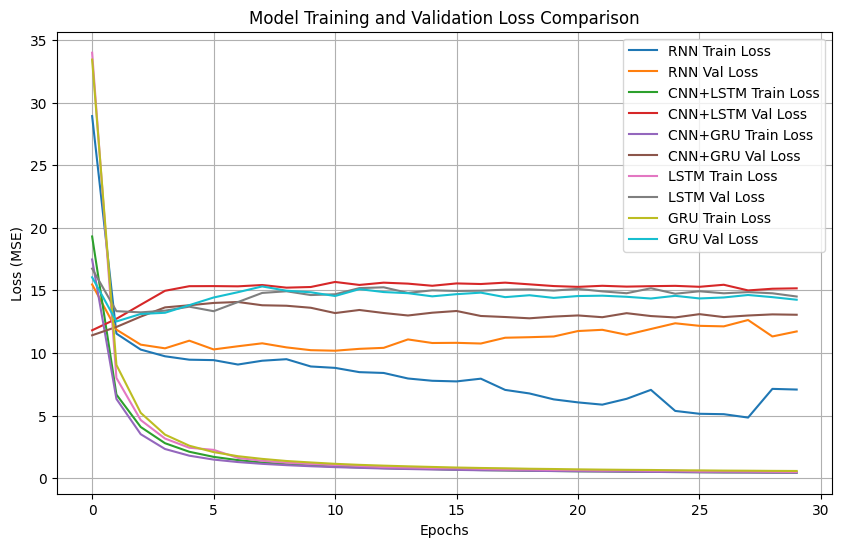

In [28]:
# Function to plot training curves
def plot_training_curves(history, model_name):
    # Training and validation loss
    plt.plot(history.history['loss'], label=f'{model_name} Train Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Val Loss')

# Plot training curves for each model
plt.figure(figsize=(10, 6))

#plot simple Stacked RNN model
plot_training_curves(history, "RNN")

# CNN + LSTM
plot_training_curves(history_cnn_lstm, "CNN+LSTM")

# CNN + GRU
plot_training_curves(history_cnn_gru, "CNN+GRU")

# LSTM
plot_training_curves(history_lstm, "LSTM")

# GRU
plot_training_curves(history_gru, "GRU")

# Add labels and legend
plt.title("Model Training and Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


## Prediction using CNN+GRU

In [30]:
# Make predictions using the CNN+GRU model
predictions = model_cnn_gru.predict(test_dataset)

# Print the shape of the predictions to verify
print("Predictions Shape:", predictions.shape)

244/244 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
Predictions Shape: (62226, 1)


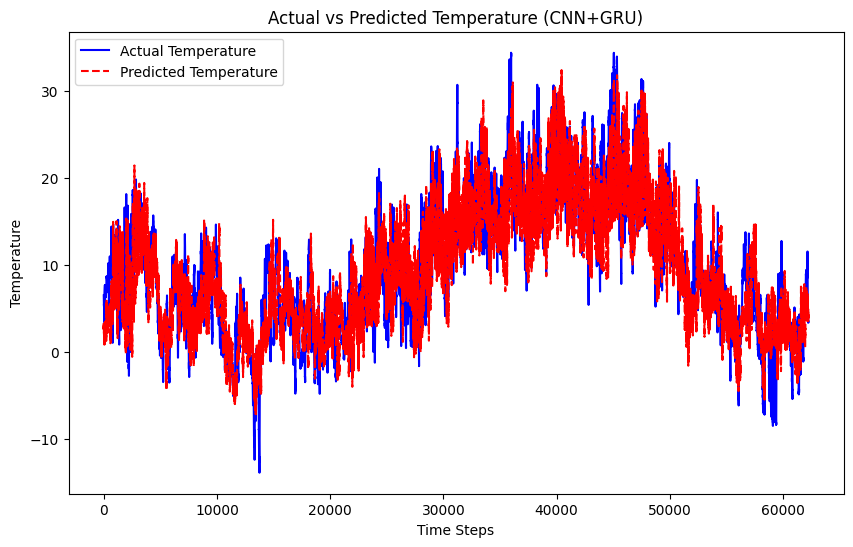

In [31]:
# Get the actual temperature values (from the test dataset)
actual_values = []
for _, labels in test_dataset:
    actual_values.append(labels.numpy())  # Extracting the actual temperature values
actual_values = np.concatenate(actual_values, axis=0)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label="Actual Temperature", color="blue")
plt.plot(predictions, label="Predicted Temperature", color="red", linestyle="--")
plt.title("Actual vs Predicted Temperature (CNN+GRU)")
plt.xlabel("Time Steps")
plt.ylabel("Temperature")
plt.legend()
plt.show()
